# Tensorflow with GPU

This notebook provides an introduction to computing on a [GPU](https://cloud.google.com/gpu) in Colab. In this notebook you will connect to a GPU, and then run some basic TensorFlow operations on both the CPU and a GPU, observing the speedup provided by using the GPU.


## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Observe TensorFlow speedup on GPU relative to CPU

This example constructs a typical convolutional neural network layer over a
random image and manually places the resulting ops on either the CPU or the GPU
to compare execution speed.

In [3]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
4.550596917000007
GPU (s):
0.09446996099998728
GPU speedup over CPU: 48x


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna
    
from sionna.utils import BinarySource, QAMSource, ebnodb2no, compute_ser, compute_ber, PlotBER
from sionna.channel import FlatFadingChannel, KroneckerModel
from sionna.channel.utils import exp_corr_mat
from sionna.mimo import lmmse_equalizer
from sionna.mapping import SymbolDemapper, Mapper, Demapper
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder

In [5]:
num_tx_ant = 4
num_rx_ant = 16
num_bits_per_symbol = 4
batch_size = 1024
qam_source = QAMSource(num_bits_per_symbol)
x = qam_source([batch_size, num_tx_ant])
print(x.shape)

(1024, 4)


Flat fading channel

In [16]:
channel = FlatFadingChannel(num_tx_ant, num_rx_ant, add_awgn=True, return_channel=True)
no = 0.2 # Noise variance of the channel

# y and h are the channel output and channel realizations.
y, h = channel([x, no])
print(y.shape)
print(h.shape)

(1024, 16)
(1024, 16, 4)


In [7]:
s = tf.cast(no*tf.eye(num_rx_ant, num_rx_ant), y.dtype)
x_hat, no_eff = lmmse_equalizer(y, h, s)

In [8]:
s = tf.cast(no*tf.eye(num_rx_ant, num_rx_ant), y.dtype)
x_hat, no_eff = lmmse_equalizer(y, h, s)

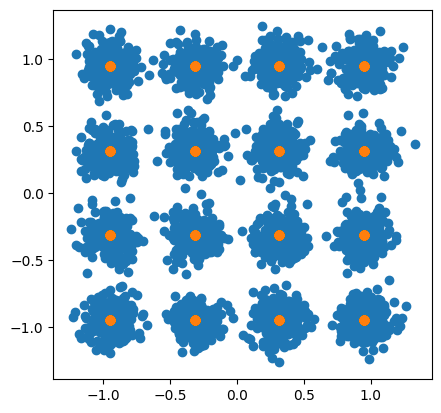

In [9]:
plt.axes().set_aspect(1.0)
plt.scatter(np.real(x_hat), np.imag(x_hat));
plt.scatter(np.real(x), np.imag(x));

In [10]:
print(no_eff.shape)

(1024, 4)


In [11]:
symbol_demapper = SymbolDemapper("qam", num_bits_per_symbol, hard_out=True)

# Get symbol indices for the transmitted symbols
x_ind = symbol_demapper([x, no])

# Get symbol indices for the received soft-symbols
x_ind_hat = symbol_demapper([x_hat, no])

compute_ser(x_ind, x_ind_hat)

<tf.Tensor: shape=(), dtype=float64, numpy=0.001708984375>

In [12]:
#Adding spatial correlation

In [13]:
# Create transmit and receive correlation matrices
r_tx = exp_corr_mat(0.4, num_tx_ant) 
r_rx = exp_corr_mat(0.9, num_rx_ant)

# Add the spatial correlation model to the channel
channel.spatial_corr = KroneckerModel(r_tx, r_rx)

In [14]:
h = channel.generate(1000000)

# Compute empirical covariance matrices
r_tx_hat = tf.reduce_mean(tf.matmul(h, h, adjoint_a=True), 0)/num_rx_ant
r_rx_hat = tf.reduce_mean(tf.matmul(h, h, adjoint_b=True), 0)/num_tx_ant

# Test that the empirical results match the theory
assert(np.allclose(r_tx, r_tx_hat, atol=1e-2))
assert(np.allclose(r_rx, r_rx_hat, atol=1e-2))

In [15]:
y, h = channel([x, no])
x_hat, no_eff = lmmse_equalizer(y, h, s)
x_ind_hat = symbol_demapper([x_hat, no])
compute_ser(x_ind, x_ind_hat)

<tf.Tensor: shape=(), dtype=float64, numpy=0.11572265625>

Extension to channel coding

Extending code to do BER stimulation

In [17]:
n = 1024 # codeword length
k = 512  # number of information bits per codeword
coderate = k/n # coderate
batch_size = 32

binary_source = BinarySource()
encoder = LDPC5GEncoder(k, n)
decoder = LDPC5GDecoder(encoder, hard_out=True)
mapper = Mapper("qam", num_bits_per_symbol)
demapper = Demapper("app", "qam", num_bits_per_symbol)

In [18]:
b = binary_source([batch_size, num_tx_ant, k])
c = encoder(b)
x = mapper(c)
x_ind = symbol_demapper([x, no]) # Get symbol indices for SER computation later on
shape = tf.shape(x)
x = tf.reshape(x, [-1, num_tx_ant])
print(x.shape)

(8192, 4)


In [20]:
y, h = channel([x, no])
x_hat, no_eff = lmmse_equalizer(y, h, s) #Transmitting the simbols over the channel

In [21]:
x_ind_hat.shape

TensorShape([1024, 4])

In [22]:
x_hat = tf.reshape(x_hat, shape)
no_eff = tf.reshape(no_eff, shape)

llr = demapper([x_hat, no_eff])
b_hat = decoder(llr)

x_ind_hat = symbol_demapper([x_hat, no])
ber = compute_ber(b, b_hat).numpy()
print("Uncoded SER : {}".format(compute_ser(x_ind, x_ind_hat)))
print("Coded BER : {}".format(compute_ber(b, b_hat)))


Uncoded SER : 0.001708984375
Coded BER : 0.0


BER simulations using a Keras model

In [23]:
sionna.config.xla_compat=True
class Model(tf.keras.Model):
    def __init__(self, spatial_corr=None):
        super().__init__()
        self.n = 1024 
        self.k = 512  
        self.coderate = self.k/self.n
        self.num_bits_per_symbol = 4
        self.num_tx_ant = 4
        self.num_rx_ant = 16
        self.binary_source = BinarySource()
        self.encoder = LDPC5GEncoder(self.k, self.n)
        self.mapper = Mapper("qam", self.num_bits_per_symbol)
        self.demapper = Demapper("app", "qam", self.num_bits_per_symbol)
        self.decoder = LDPC5GDecoder(self.encoder, hard_out=True)
        self.channel = FlatFadingChannel(self.num_tx_ant,
                                         self.num_rx_ant,
                                         spatial_corr=spatial_corr,
                                         add_awgn=True,
                                         return_channel=True)
        
    @tf.function(jit_compile=True)
    def call(self, batch_size, ebno_db):
        b = self.binary_source([batch_size, self.num_tx_ant, self.k])
        c = self.encoder(b)
        
        x = self.mapper(c)
        shape = tf.shape(x)
        x = tf.reshape(x, [-1, self.num_tx_ant])
        
        no = ebnodb2no(ebno_db, self.num_bits_per_symbol, self.coderate)
        no *= np.sqrt(self.num_rx_ant)

        y, h = self.channel([x, no])
        s = tf.complex(no*tf.eye(self.num_rx_ant, self.num_rx_ant), 0.0)
        
        x_hat, no_eff = lmmse_equalizer(y, h, s)
        
        x_hat = tf.reshape(x_hat, shape)
        no_eff = tf.reshape(no_eff, shape)
        
        llr = self.demapper([x_hat, no_eff])
        b_hat = self.decoder(llr)
        
        return b,  b_hat

In [24]:
ber_plot = PlotBER()

In [25]:
model1 = Model()

ber_plot.simulate(model1,
        np.arange(-2.5, 0.25, 0.25),
        batch_size=4096,
        max_mc_iter=1000,
        num_target_block_errors=100,
        legend="Uncorrelated",
        show_fig=False);

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -2.5 | 1.1056e-01 | 9.1559e-01 |      927435 |     8388608 |        15001 |       16384 |        20.4 |reached target block errors
    -2.25 | 7.9050e-02 | 7.8339e-01 |      663118 |     8388608 |        12835 |       16384 |         0.8 |reached target block errors
     -2.0 | 4.9942e-02 | 5.9241e-01 |      418942 |     8388608 |         9706 |       16384 |         0.8 |reached target block errors
    -1.75 | 2.6698e-02 | 3.6536e-01 |      223963 |     8388608 |         5986 |       16384 |         0.8 |reached target block errors
     -1.5 | 1.1918e-02 | 1.9379e-01 |       99975 |     8388608 |         3175 |       16384 |         0.8 |reached target block errors
    -1.25 | 4.4986e-03 | 8.0505e-02 |       37737 |     8388608 |

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 7.2249e-02 | 7.1844e-01 |      606071 |     8388608 |        11771 |       16384 |         7.4 |reached target block errors
     0.25 | 4.7019e-02 | 5.4132e-01 |      394421 |     8388608 |         8869 |       16384 |         0.9 |reached target block errors
      0.5 | 2.7080e-02 | 3.5498e-01 |      227164 |     8388608 |         5816 |       16384 |         0.9 |reached target block errors
     0.75 | 1.3981e-02 | 2.0380e-01 |      117284 |     8388608 |         3339 |       16384 |         0.9 |reached target block errors
      1.0 | 6.1554e-03 | 9.6802e-02 |       51635 |     8388608 |         1586 |       16384 |         0.9 |reached target block errors
     1.25 | 2.2973e-03 | 4.0100e-02 |       19271 |     8388608 |

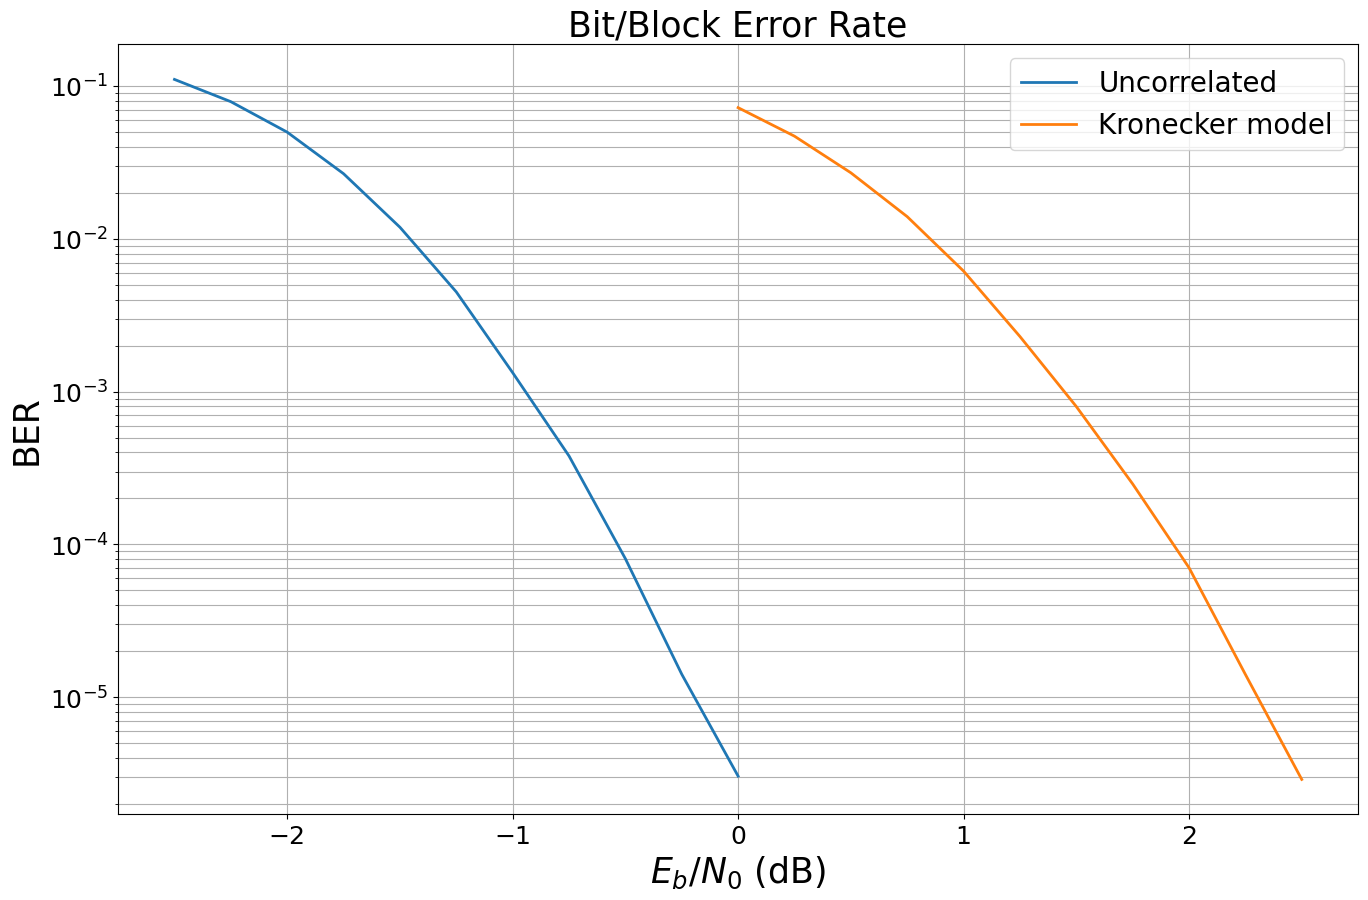

In [26]:
r_tx = exp_corr_mat(0.4, num_tx_ant) 
r_rx = exp_corr_mat(0.7, num_rx_ant)
model2 = Model(KroneckerModel(r_tx, r_rx))

ber_plot.simulate(model2,
        np.arange(0,2.6,0.25),
        batch_size=4096,
        max_mc_iter=1000,
        num_target_block_errors=200,
        legend="Kronecker model");
